# 🛡️ Lab 2: Building an Email Phishing Classifier Using LangGraph

In this lab, you’ll build a **multi-agent phishing classifier** using the LangGraph framework.  
Each agent performs a focused task: **feature extraction, threat intelligence, URL reputation, and final risk-based decisioning**.

This lab demonstrates:
- How to structure GenAI tools into agentic flows
- Collaboration between multiple AI agents in a pipeline
- Security use cases like phishing detection and automation

> 💡 This is a simulation of how GenAI can power email security, SOC workflows, and auto-triage pipelines.


**LangGraph** - A lightweight framework for building deterministic multi-agent workflows.
You define a graph of nodes (agents/functions) and edges (the order/conditions they run). Each node reads/writes a shared state.
*Flowchart meets LLMs.*

[Reference](https://www.langchain.com/langgraph)

## ⚙️ Setup Instructions

This lab uses:
- `LangGraph`: Build multi-agent workflows
- `LangChain` + `OpenAI`: Core LLM agents
- `requests`: For VirusTotal reputation lookups

Install all required libraries with:

```bash
!pip install langgraph langchain langchain-openai openai requests --quiet



## Email Phising Classifier




In [ ]:
!pip install langgraph langchain langchain-openai openai requests --quiet

import openai
import requests
import json
import re
from datetime import datetime
from typing import Dict, List, TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
import openai
from google.colab import userdata

# API Keys (set these in your environment)
OPENAI_API_KEY = userdata.get('openai.api_key')  # Replace with your key
VIRUSTOTAL_API_KEY = userdata.get('virustotal.api_key')  # Replace with your key

In [ ]:
# Initialize LLM for agents
llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0.1)

print("🤖 Agentic Framework Setup Complete!")
print("🔗 LangGraph initialized")
print("🧠 Multiple AI agents ready")


🤖 Agentic Framework Setup Complete!
🔗 LangGraph initialized
🧠 Multiple AI agents ready


In [ ]:
# =============================================================================
# Define Agent State (Shared Memory)
# =============================================================================
class EmailSecurityState(TypedDict):
    """Shared state between all agents"""
    email_content: str
    analysis_stage: str

    # Data collected by agents
    extracted_features: Dict
    threat_intelligence: Dict
    url_reputation: Dict
    behavioral_analysis: Dict

    # Agent decisions
    agent_recommendations: List[Dict]
    risk_scores: Dict

    # Final outputs
    final_decision: Dict
    automation_actions: List[str]
    confidence_level: float

print("📊 Agent State Schema Defined")
print("🔄 Shared memory system ready for agent collaboration")

📊 Agent State Schema Defined
🔄 Shared memory system ready for agent collaboration


### 🔍 Agent 1: Email Analyzer

This agent parses the raw email to extract:
- URLs
- Urgency signals
- Subject & content patterns

It sets the foundation for all later security agents.


In [ ]:
# =============================================================================
# Agent 1 - Email Analyzer Agent
# =============================================================================
def email_analyzer_agent(state: EmailSecurityState) -> EmailSecurityState:
    """
    Agent 1: Extracts features and performs initial email analysis
    """
    print("🔍 AGENT 1: Email Analyzer - Starting analysis...")

    email_content = state["email_content"]

    # Extract features
    urls = re.findall(r'https?://[^\s<>"]+', email_content)

    # Create analysis prompt for this agent
    analyzer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Email Analyzer Agent. Your job is to extract key features and patterns from emails.

        Extract:
        1. Sender information and reputation indicators
        2. Subject line analysis (urgency, manipulation)
        3. Content structure and tone
        4. URLs and domains found
        5. Attachment indicators
        6. Authentication markers

        Respond in JSON format with your analysis."""),
        ("user", "Analyze this email:\n\n{email_content}")
    ])

    try:
        chain = analyzer_prompt | llm
        response = chain.invoke({"email_content": email_content})

        # Parse agent response
        agent_analysis = {
            "urls": urls,
            "url_count": len(urls),
            "content_length": len(email_content),
            "has_urgency": bool(re.search(r'\b(urgent|immediate|expire|deadline)\b', email_content, re.IGNORECASE)),
            "agent_insights": response.content,
            "analysis_timestamp": datetime.now().isoformat()
        }

        state["extracted_features"] = agent_analysis
        state["analysis_stage"] = "features_extracted"

        print(f"✅ Agent 1 Complete: {len(urls)} URLs found, urgency detected: {agent_analysis['has_urgency']}")

    except Exception as e:
        print(f"❌ Agent 1 Error: {e}")
        state["extracted_features"] = {"error": str(e)}

    return state


### 🛡 Agent 2: Threat Intelligence Analysis

This agent checks for:
- Phishing language
- BEC indicators
- Social engineering signals

It builds on extracted features and applies LLM-based reasoning.


In [ ]:
# =============================================================================
# Agent 2 - Threat Intelligence Agent
# =============================================================================
def threat_intelligence_agent(state: EmailSecurityState) -> EmailSecurityState:
    """
    Agent 2: Gathers threat intelligence and performs behavioral analysis
    """
    print("🛡️ AGENT 2: Threat Intelligence - Analyzing threats...")

    email_content = state["email_content"]
    features = state.get("extracted_features", {})

    # Threat analysis prompt
    threat_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Threat Intelligence Agent. You specialize in:

        1. Phishing pattern recognition
        2. Social engineering tactics identification
        3. Malware delivery method analysis
        4. Business Email Compromise (BEC) detection
        5. Advanced Persistent Threat (APT) indicators

        Analyze for sophisticated attack patterns and provide threat assessment."""),
        ("user", """Analyze this email for threat patterns:

        EMAIL: {email_content}

        FEATURES: {features}

        Provide threat intelligence assessment in JSON format.""")
    ])

    try:
        chain = threat_prompt | llm
        response = chain.invoke({
            "email_content": email_content,
            "features": json.dumps(features)
        })

        # Agent's threat assessment
        threat_analysis = {
            "agent_response": response.content,
            "phishing_indicators": len(re.findall(r'\b(verify|confirm|click|urgent|suspend)\b', email_content, re.IGNORECASE)),
            "social_engineering_score": 0.7 if features.get("has_urgency") else 0.3,
            "analysis_timestamp": datetime.now().isoformat()
        }

        state["threat_intelligence"] = threat_analysis
        state["analysis_stage"] = "threat_analyzed"

        print(f"✅ Agent 2 Complete: Social engineering score: {threat_analysis['social_engineering_score']:.1f}")

    except Exception as e:
        print(f"❌ Agent 2 Error: {e}")
        state["threat_intelligence"] = {"error": str(e)}

    return state


### 🔗 Agent 3: URL Reputation Check

This agent sends URLs to VirusTotal and checks if they appear suspicious or malicious.  
It enhances the LLM’s reasoning with real threat intelligence.


In [ ]:
# =============================================================================
# Agent 3 - URL Reputation Agent
# =============================================================================
def url_reputation_agent(state: EmailSecurityState) -> EmailSecurityState:
    """
    Agent 3: Specialized in URL analysis and reputation checking
    """
    print("🔗 AGENT 3: URL Reputation - Checking URL safety...")

    features = state.get("extracted_features", {})
    urls = features.get("urls", [])

    if not urls:
        state["url_reputation"] = {"message": "No URLs to analyze"}
        return state

    # URL analysis with external intelligence
    url_results = []

    for url in urls[:3]:  # Limit to 3 URLs
        print(f"   🔍 Checking: {url[:50]}...")

        # VirusTotal check (simplified)
        try:
            headers = {"x-apikey": VIRUSTOTAL_API_KEY}
            response = requests.post(
                "https://www.virustotal.com/api/v3/urls",
                headers=headers,
                data={"url": url}
            )

            if response.status_code == 200:
                result = {
                    "url": url,
                    "status": "submitted_to_vt",
                    "reputation": "checking",
                    "agent_assessment": "URL submitted for analysis"
                }
            else:
                result = {
                    "url": url,
                    "status": "vt_error",
                    "reputation": "unknown",
                    "agent_assessment": f"VT API error: {response.status_code}"
                }

        except Exception as e:
            result = {
                "url": url,
                "status": "error",
                "reputation": "unknown",
                "agent_assessment": f"Analysis failed: {str(e)}"
            }

        url_results.append(result)

    state["url_reputation"] = {
        "results": url_results,
        "total_urls": len(urls),
        "analysis_timestamp": datetime.now().isoformat()
    }

    state["analysis_stage"] = "urls_analyzed"
    print(f"✅ Agent 3 Complete: {len(url_results)} URLs processed")

    return state


### 🎯 Agent 4: Decision Coordinator

This agent:
- Aggregates all previous findings
- Computes a risk score
- Makes the final recommendation (ALLOW, BLOCK, etc.)
- Suggests automation actions

The output mimics a real-world SOC triage decision.


In [ ]:
# =============================================================================
# Agent 4 - Decision Coordinator Agent
# =============================================================================
def decision_coordinator_agent(state: EmailSecurityState) -> EmailSecurityState:
    """
    Agent 4: Coordinates all agent findings and makes final decision
    """
    print("🎯 AGENT 4: Decision Coordinator - Making final assessment...")

    # Gather all agent findings
    features = state.get("extracted_features", {})
    threats = state.get("threat_intelligence", {})
    urls = state.get("url_reputation", {})

    # Decision coordination prompt
    decision_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Decision Coordinator Agent. You synthesize findings from all security agents:

        1. Email Analyzer Agent findings
        2. Threat Intelligence Agent assessment
        3. URL Reputation Agent results

        Make the final security decision considering all agent inputs."""),
        ("user", """Coordinate the final decision based on all agent findings:

        EMAIL ANALYZER FINDINGS:
        {features}

        THREAT INTELLIGENCE:
        {threats}

        URL REPUTATION:
        {urls}

        Provide final decision in JSON format with:
        - recommendation (ALLOW/INVESTIGATE/QUARANTINE/BLOCK)
        - confidence_level (0.0-1.0)
        - risk_score (0.0-1.0)
        - reasoning
        - automation_actions""")
    ])

    try:
        chain = decision_prompt | llm
        response = chain.invoke({
            "features": json.dumps(features),
            "threats": json.dumps(threats),
            "urls": json.dumps(urls)
        })

        # Calculate risk score from agent inputs
        risk_score = 0.0

        # Factor in different agent findings
        if features.get("has_urgency"):
            risk_score += 0.3

        social_eng_score = threats.get("social_engineering_score", 0)
        risk_score += social_eng_score * 0.4

        url_count = features.get("url_count", 0)
        if url_count > 2:
            risk_score += 0.2

        risk_score = min(risk_score, 1.0)  # Cap at 1.0

        # Determine recommendation
        if risk_score >= 0.8:
            recommendation = "BLOCK"
            automation_actions = ["block_sender", "quarantine_email", "alert_security_team"]
        elif risk_score >= 0.6:
            recommendation = "QUARANTINE"
            automation_actions = ["quarantine_email", "flag_for_review"]
        elif risk_score >= 0.4:
            recommendation = "INVESTIGATE"
            automation_actions = ["flag_for_review", "monitor_sender"]
        else:
            recommendation = "ALLOW"
            automation_actions = ["deliver_email"]

        final_decision = {
            "recommendation": recommendation,
            "risk_score": risk_score,
            "confidence_level": 0.85,  # High confidence in multi-agent decision
            "reasoning": f"Multi-agent analysis: risk_score={risk_score:.2f}",
            "coordinator_analysis": response.content,
            "timestamp": datetime.now().isoformat()
        }

        state["final_decision"] = final_decision
        state["automation_actions"] = automation_actions
        state["confidence_level"] = final_decision["confidence_level"]
        state["analysis_stage"] = "decision_complete"

        print(f"✅ Agent 4 Complete: {recommendation} (risk: {risk_score:.2f}, confidence: {final_decision['confidence_level']:.1%})")

    except Exception as e:
        print(f"❌ Agent 4 Error: {e}")
        state["final_decision"] = {"error": str(e)}

    return state


### 🔧 Assemble the Multi-Agent Workflow

Connect agents in a sequence:
1 → 2 → 3 → 4 → END

Compile the graph so LangGraph can orchestrate the agent pipeline.


In [ ]:
# =============================================================================
# Build Agentic Workflow with LangGraph
# =============================================================================
def create_agentic_workflow():
    """Create the multi-agent workflow using LangGraph"""

    # Initialize workflow
    workflow = StateGraph(EmailSecurityState)

    # Add agent nodes
    workflow.add_node("email_analyzer", email_analyzer_agent)
    workflow.add_node("threat_intelligence", threat_intelligence_agent)
    workflow.add_node("url_reputation", url_reputation_agent)
    workflow.add_node("decision_coordinator", decision_coordinator_agent)

    # Define agent collaboration flow
    workflow.set_entry_point("email_analyzer")
    workflow.add_edge("email_analyzer", "threat_intelligence")
    workflow.add_edge("threat_intelligence", "url_reputation")
    workflow.add_edge("url_reputation", "decision_coordinator")
    workflow.add_edge("decision_coordinator", END)

    # Compile the agentic system
    app = workflow.compile()

    print("🤖 Multi-Agent Workflow Created!")
    print("🔄 Agent collaboration pipeline ready")

    return app

# Create the agentic system
agentic_system = create_agentic_workflow()


🤖 Multi-Agent Workflow Created!
🔄 Agent collaboration pipeline ready


In [ ]:
def show_workflow_diagram():
    """Generate visual diagram like in LangGraph documentation"""

    # Try to display PNG diagram (requires IPython/Jupyter)
    from IPython.display import Image, display

    print("🎨 Generating visual workflow diagram...")

    # Generate PNG diagram
    diagram_png = agentic_system.get_graph().draw_mermaid_png()
    display(Image(diagram_png))

    print("✅ Visual diagram displayed above!")

🔍 Method 1: PNG Diagram (like in docs)
🎨 Generating visual workflow diagram...


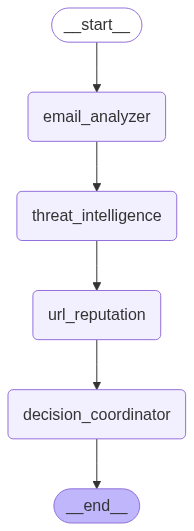

✅ Visual diagram displayed above!


In [ ]:
print("🔍 Method 1: PNG Diagram (like in docs)")
show_workflow_diagram()

## 🚀 Run the Multi-Agent Classifier

Use `run_agentic_analysis()` to test different email scenarios.  
You'll see each agent's log messages, the decision flow, and the final verdict with automation actions.

> 🧪 This is your simulated phishing detection pipeline — powered by AI agents!


In [ ]:
# =============================================================================
# Execute Agentic Analysis
# =============================================================================
def run_agentic_analysis(email_content: str, email_name: str = "Email"):
    """Run the complete multi-agent analysis"""

    print(f"🚀 STARTING AGENTIC ANALYSIS: {email_name}")
    print("🤖 Deploying 4 AI agents for collaborative analysis")
    print("="*70)

    # Initialize state
    initial_state = {
        "email_content": email_content,
        "analysis_stage": "starting",
        "extracted_features": {},
        "threat_intelligence": {},
        "url_reputation": {},
        "behavioral_analysis": {},
        "agent_recommendations": [],
        "risk_scores": {},
        "final_decision": {},
        "automation_actions": [],
        "confidence_level": 0.0
    }

    # Execute multi-agent workflow
    final_state = agentic_system.invoke(initial_state)

    # Display results
    decision = final_state.get("final_decision", {})
    actions = final_state.get("automation_actions", [])

    print(f"\n🎉 AGENTIC ANALYSIS COMPLETE!")
    print(f"🎯 Decision: {decision.get('recommendation', 'UNKNOWN')}")
    print(f"📊 Risk Score: {decision.get('risk_score', 0):.2f}")
    print(f"🔒 Confidence: {decision.get('confidence_level', 0):.1%}")

    print(f"\n⚡ Automated Actions:")
    for i, action in enumerate(actions, 1):
        print(f"   {i}. {action}")

    return final_state


## Testing

## 🧪 Test Cases: Simulating Real Emails

We’ve prepared 3 cases:
- A **sophisticated phishing email** with urgency + malicious links
- A **legitimate business notification**
- A **BEC (Business Email Compromise)** scenario

Each test is processed by the agentic system, producing a decision and risk score.

###Run Tests on Realistic Phishing and Benign Emails

Use real-world phishing samples (from URLHaus) and clean emails.  
See how the system performs across different scenarios.


In [ ]:
# =============================================================================
# Test Agentic System with Real Threats
# =============================================================================

# Fetch URLhaus samples for testing
def get_urlhaus_samples():
    try:
        response = requests.get("https://urlhaus-api.abuse.ch/v1/urls/recent/",
                              data={"format": "json"})
        if response.status_code == 200:
            data = response.json()
            return [item["url"] for item in data["urls"][:2]]
        else:
            return ["http://112.198.195.68:47568/i", "http://phishing-test.example/login"]
    except:
        return ["http://112.198.195.68:47568/i", "http://phishing-test.example/login"]

malicious_urls = get_urlhaus_samples()

# Test cases for agentic system
test_cases = {
    "sophisticated_phishing": f"""From: security@micr0soft.com
Subject: URGENT: Account Security Alert

Your Microsoft account has suspicious activity. Immediate verification required.

Verify here: {malicious_urls[0]}
Secondary link: {malicious_urls[1]}

You have 24 hours before account suspension.

Microsoft Security Team
""",

    "legitimate_business": """From: noreply@github.com
Subject: Weekly GitHub Activity Summary

Hi Developer,

Your GitHub activity this week:
- 7 commits pushed to main
- 3 pull requests merged
- 2 issues resolved

View details: https://github.com/notifications
Manage settings: https://github.com/settings

Happy coding!
GitHub Team
""",

    "bec_attempt": """From: CEO John Smith <john.smith@company.com>
Subject: Urgent Wire Transfer - Confidential

Hi Finance Team,

Need urgent wire transfer processed today for confidential acquisition.

Amount: $450,000
Account details will follow separately.

This is time-sensitive. Process immediately.

John Smith, CEO
Sent from mobile
"""
}



In [ ]:
print("🧪 TESTING AGENTIC SYSTEM WITH MULTIPLE SCENARIOS")
print("="*70)

results = {}
for name, email in test_cases.items():
    print(f"\n🎯 TESTING: {name.upper()}")
    print("-" * 50)

    result = run_agentic_analysis(email, name)
    results[name] = result

    print(f"\n📋 AGENT DECISIONS SUMMARY:")
    decision = result.get("final_decision", {})
    print(f"   Recommendation: {decision.get('recommendation', 'UNKNOWN')}")
    print(f"   Risk Level: {decision.get('risk_score', 0):.2f}")
    print(f"   Automation: {len(result.get('automation_actions', []))} actions triggered")

print(f"\n✅ AGENTIC TESTING COMPLETE!")
print(f"🤖 {len(test_cases)} scenarios analyzed by multi-agent system")
print(f"📊 Results stored in 'results' dictionary")

🧪 TESTING AGENTIC SYSTEM WITH MULTIPLE SCENARIOS

🎯 TESTING: SOPHISTICATED_PHISHING
--------------------------------------------------
🚀 STARTING AGENTIC ANALYSIS: sophisticated_phishing
🤖 Deploying 4 AI agents for collaborative analysis
🔍 AGENT 1: Email Analyzer - Starting analysis...
✅ Agent 1 Complete: 2 URLs found, urgency detected: True
🛡️ AGENT 2: Threat Intelligence - Analyzing threats...
✅ Agent 2 Complete: Social engineering score: 0.7
🔗 AGENT 3: URL Reputation - Checking URL safety...
   🔍 Checking: http://112.198.195.68:47568/i...
   🔍 Checking: http://phishing-test.example/login...
✅ Agent 3 Complete: 2 URLs processed
🎯 AGENT 4: Decision Coordinator - Making final assessment...
✅ Agent 4 Complete: INVESTIGATE (risk: 0.58, confidence: 85.0%)

🎉 AGENTIC ANALYSIS COMPLETE!
🎯 Decision: INVESTIGATE
📊 Risk Score: 0.58
🔒 Confidence: 85.0%

⚡ Automated Actions:
   1. flag_for_review
   2. monitor_sender

📋 AGENT DECISIONS SUMMARY:
   Recommendation: INVESTIGATE
   Risk Level: 0.58


In [ ]:
print("🧪 TESTING AGENTIC SYSTEM WITH MULTIPLE SCENARIOS")
print("=" * 70)

results = {}

for name, email in test_cases.items():
    print("\n" + "=" * 70)
    print(f"🎯 TESTING SCENARIO: {name.upper()}")
    print("=" * 70)

    result = run_agentic_analysis(email, name)
    results[name] = result

    print("\n📋 AGENT DECISIONS SUMMARY:")
    decision = result.get("final_decision", {})
    print(f"   🔸 Recommendation : {decision.get('recommendation', 'UNKNOWN')}")
    print(f"   🔸 Risk Level     : {decision.get('risk_score', 0):.2f}")
    print(f"   🔸 Automation     : {len(result.get('automation_actions', []))} actions triggered")

print("\n" + "=" * 70)
print("✅ AGENTIC TESTING COMPLETE")
print("=" * 70)
print(f"🤖 Total Scenarios Analyzed: {len(test_cases)}")
print("📊 Results are stored in the `results` dictionary for further analysis")


🧪 TESTING AGENTIC SYSTEM WITH MULTIPLE SCENARIOS

🎯 TESTING SCENARIO: SOPHISTICATED_PHISHING
🚀 STARTING AGENTIC ANALYSIS: sophisticated_phishing
🤖 Deploying 4 AI agents for collaborative analysis
🔍 AGENT 1: Email Analyzer - Starting analysis...
✅ Agent 1 Complete: 2 URLs found, urgency detected: True
🛡️ AGENT 2: Threat Intelligence - Analyzing threats...
✅ Agent 2 Complete: Social engineering score: 0.7
🔗 AGENT 3: URL Reputation - Checking URL safety...
   🔍 Checking: http://112.198.195.68:47568/i...
   🔍 Checking: http://phishing-test.example/login...
✅ Agent 3 Complete: 2 URLs processed
🎯 AGENT 4: Decision Coordinator - Making final assessment...
✅ Agent 4 Complete: INVESTIGATE (risk: 0.58, confidence: 85.0%)

🎉 AGENTIC ANALYSIS COMPLETE!
🎯 Decision: INVESTIGATE
📊 Risk Score: 0.58
🔒 Confidence: 85.0%

⚡ Automated Actions:
   1. flag_for_review
   2. monitor_sender

📋 AGENT DECISIONS SUMMARY:
   🔸 Recommendation : INVESTIGATE
   🔸 Risk Level     : 0.58
   🔸 Automation     : 2 actions 

## Risk & Governance Mapping

This agentic email classifier lab aligns with multiple categories from both the **OWASP LLM Top 10** and the **NIST AI Risk Management Framework (RMF)**. Here's how:

---

### 🔐 OWASP LLM Top 10 Mapping

| Component                          | OWASP Category                       | Why It Applies                                                  |
|-----------------------------------|--------------------------------------|-----------------------------------------------------------------|
| Email Analyzer Agent              | **LLM01: Prompt Injection**          | Demonstrates how prompt structure controls model behavior       |
| Threat Intelligence Agent         | **LLM04: Overreliance**              | Relies on LLM to assess threat patterns — potential false sense of accuracy |
| URL Reputation Agent (VT lookup)  | **LLM06: Insecure Output Handling**  | Relies on model output + external API trust for automation      |
| Final Decision Agent              | **LLM08: Excessive Agency**          | Makes recommendations and triggers automation actions           |
| Shared Memory (LangGraph state)   | **LLM03: Training Data Poisoning**   | Uses structured state to reduce risk of hallucination spillover |

---

### 🧭 NIST AI RMF Mapping

| RMF Core Function | What This Lab Demonstrates                                            |
|-------------------|------------------------------------------------------------------------|
| **Map**           | Identifies emails and agent states as input elements                   |
| **Measure**       | Risk score, confidence, social engineering signal, prompt effectiveness |
| **Manage**        | Controlled decision making, action thresholds, structured memory        |
| **Govern**        | Structured agent outputs, observable decision paths, auditability       |

---

> 🛡️ This lab builds confidence in deploying LLM-powered pipelines in high-risk environments (e.g., SOCs, phishing filters) by emphasizing structure, multi-agent collaboration, and secure reasoning.


## 🧠 MITRE ATLAS Tactic Mapping

This lab simulates a GenAI-based detection pipeline that aligns with several adversarial tactics outlined in the MITRE ATLAS framework:

| Lab Component                   | MITRE ATLAS Tactic               | Description                                                                 |
|--------------------------------|----------------------------------|-----------------------------------------------------------------------------|
| Email Analyzer Agent           | **TA001: Reconnaissance**        | Detects characteristics often used in spear phishing and targeting          |
| Threat Intelligence Agent      | **TA005: Delivery**              | Identifies delivery vectors like social engineering and malware injection   |
| URL Reputation Agent           | **TA006: Credential Access**     | Validates reputation of URLs designed to steal credentials                  |
| Decision Coordinator Agent     | **TA010: Impact**                | Makes security recommendations to block or quarantine malicious emails      |
| Multi-agent coordination       | **TA009: Model Exploitation**    | Demonstrates how system-level aggregation can help detect AI manipulation   |

---

> 🧩 This agentic framework could be adapted for red-teaming exercises or threat emulation environments using adversarial LLM behaviors.

**Learn more:** [https://atlas.mitre.org](https://atlas.mitre.org)


## 🧪 Things to Try (Advanced Variants)

Explore ways to extend, stress-test, or productionize your agentic email classifier:

---

### 🔁 Workflow Variants
- Run agents in **parallel** (e.g., URL reputation + LLM reasoning simultaneously)
- Add a **Human-in-the-Loop (HITL)** checkpoint before acting on high-risk emails
- Insert a **guardrails agent** to validate output format, tone, or confidence

---

### ✍️ Prompt Engineering Variants
- Ask the model: _“Why might this be phishing?”_ to elicit reasoning chains
- Use **few-shot prompts** with known phishing patterns (BEC, invoice scams)
- Force **structured output**: JSON, Markdown, or tagged evidence with confidence scores

---

### 🔗 External Threat Validation
- Add a **WHOIS domain age lookup** to detect newly registered domains
- Integrate with **PhishTank**, **AbuseIPDB**, or custom threat intelligence feeds
- Flag inconsistencies like **display name ≠ email domain** or suspicious reply-to headers

---

> 💡 Bonus: Observe what happens when agents **disagree** — should the workflow defer to a human? Retry with a fallback model? Or just flag for review?


# Agentic Frameworks for Security

## Why Consider Agentic Frameworks?

Traditional prompt engineering handles single interactions, but security workflows often require **multi-step reasoning**:
- Analyze logs → Research threats → Correlate data → Generate recommendations
- Review code → Test vulnerabilities → Suggest fixes → Validate solutions

**Agentic frameworks** enable AI to break down complex security tasks autonomously.

---

## 🚀 Framework Comparison

| **Framework** | **Pros** | **Cons** |
|---------------|----------|----------|
| **LangChain Agents** | • Extensive tool ecosystem<br>• Mature documentation and community<br>• Multiple agent types (ReAct, Plan-and-Execute)<br>• Good existing security tool integration | • Can be complex for simple use cases<br>• Performance overhead with complex chains<br>• Memory management can be tricky |
| **AutoGen (Microsoft)** | • Excellent multi-agent conversations<br>• Built-in code execution capabilities<br>• Strong Microsoft ecosystem integration<br>• Good for simulating team discussions | • Relatively new, smaller community<br>• Limited pre-built security tools<br>• Can get expensive with multiple agents |
| **CrewAI** | • Role-based agent design<br>• Simple workflow definition<br>• Built-in task delegation<br>• Good for specialized security roles | • Less flexible than LangChain<br>• Newer framework, fewer examples<br>• Limited tool integration options |
| **LangGraph (2024)** | • State-based agent workflows<br>• Better control flow than basic chains<br>• Built on LangChain but more structured<br>• Excellent for complex investigations | • Very new, limited documentation<br>• Steeper learning curve<br>• Fewer community examples |
| **Swarm (OpenAI - 2024)** | • Lightweight and simple<br>• Excellent agent handoffs<br>• Direct OpenAI integration<br>• Good for specialized teams | • OpenAI-only (no other LLM support)<br>• Very new, minimal ecosystem<br>• Limited tool integration |
| **Agency Swarm** | • Built for production environments<br>• Good error handling and monitoring<br>• Strong async support<br>• Specialized for business workflows | • Commercial focus, less open-source<br>• Smaller community<br>• Documentation still growing |
| **Phidata** | • Built-in security-focused tools<br>• Good RAG integration for security docs<br>• Simple agent creation<br>• Strong tool ecosystem | • Newer framework (2024)<br>• Limited advanced agent patterns<br>• Smaller community |
| **MCP (Anthropic - 2024)** | • Standardized tool integration protocol<br>• Secure by design (sandboxed execution)<br>• Cross-platform compatibility<br>• Built-in security and permission controls | • Very new (late 2024), early adoption<br>• Limited existing MCP servers<br>• Requires protocol understanding<br>• Fewer examples available |

---
